# Read ASTRAL PSL mean meteorology files
## me2: radiometer, sea snake, pressure
## me1: ORG, 

In [1]:
# usings

using Pkg; Pkg.activate(".")
using Dates
using Printf
using PyPlot

  Activating project at `~/Projects/ASTRAL/mast`


In [2]:
# general PSL DAS readers

# utility functions
m2n(x) = ismissing(x) ? NaN : x
pd = permutedims

# parameters for ASTRAL - feed defaults to functions
baseyear = 2024
mastdir = "./data/PSL/"
# ncolumn = 22 # change for different file types

"yearday from Date or DateTime"
yday(dt) = Dates.value(Date(dt) - Date(year(dt)-1,12,31))
yday(ddd::String) = parse(Int, ddd)

"return all filenames with prefix and date dt"
function get_das_filenames(prefix, yd::Integer, mastdir=mastdir)
    filter(startswith(prefix), 
           readdir(joinpath(mastdir, @sprintf("%03d",yd))))
end
function get_das_filenames(prefix, dt::Date, mastdir=mastdir)
    get_das_filenames(prefix, yday(dt), mastdir)
end
"return filenames with prefix matching hour of dt"
function get_das_filenames(prefix, dt::DateTime, mastdir=mastdir)
    hh = @sprintf("%02d", Dates.value(Hour(dt)))
    filter( endswith(hh*"_raw.txt"),
            get_das_filenames(prefix, Date(dt), mastdir) )
end

"return vector of full paths of all files with prefix and date"
function get_das_pathfiles(prefix, dt, mastdir=mastdir)
    joinpath.(mastdir,
              @sprintf("%03d",yday(dt)),
              get_das_filenames(prefix, dt, mastdir))
end

"Convert a PSL date to a DateTime."
function psldatetime(d::Date, hr::Integer, psltime::AbstractString)
    mm  = Minute(     parse(Int32, psltime[1:2]))
    SS  = Second(     parse(Int32, psltime[3:4]))
    sss = Millisecond(parse(Int32, psltime[5:7]))
    DateTime(Date(d)) + Hour(hr) + mm + SS + sss
end
function psldatetime(d::Date, hr::Integer=0, minute::Real=0)
    DateTime(Date(d)) + Hour(hr) + Minute(minute) + Second(second)
end
function psldatetime(yearday::Integer, hr::Integer=0; minute::Real=0, year=baseyear)
    DateTime(year,12,31) + Day(yearday) + Hour(hr) + Minute(minute)
end
# psldatetime(Date(2024,5,8), hr, "0606111")
# To get filename from the date, hour
# psldatefile(prefix, psldatetime(d, hr, psltime))

# file format default parameters
nheader = 1
# dt = DateTime(2024,5,8,11,0,0)
# pathfilename = get_das_pathfiles(prefix, dt::DateTime, mastdir=mastdir)

"read das data and put in a dictionary"
function read_das_dict(pathfilename, keys;
    nheader=nheader,
    nsample=sum(countlines.(pathfilename) .- nheader),
    ncolumn=length(keys)-1 ) # default columns in data excluding datestamp

    # read data from file
    datatime, X = read_das_data(pathfilename; 
        nheader=nheader,
        nsample=nsample,
        ncolumn=ncolumn ) # specifying manages memory best
    
    return das_dict(keys, datatime, X) # returns dict
end

parseblank2missing(T, s) = isempty(s) ? missing : parse(T, s)

"read and parse one file"
function read_das_data(pathfilename::AbstractString;
    nheader=1, 
    nsample=countlines(pathfilenames) - nheader, 
    ncolumn=22 )

    # trivially iterate over 1-vector
    dt, X = read_scs_data(pathfilename[1:1]; 
        nheader=nheader, nsample=nsample, ncolumn=ncolumn )
    return dt, X
end

"read and concatenate data from multiple files"
function read_das_data(pathfilename::Vector{<:AbstractString};
    nheader=1,
    nsample=sum( countlines.(pathfilenames) - nheader ),
    ncolumn=26 ) # data, not including timestamp

    # preallocate the data
    # psltime = Vector{String}(undef, nsample) # will point to data as it is read
    psldt = Vector{DateTime}(undef, nsample) # will point to data as it is read
    X = Array{Union{Float32,Missing}, 2}(undef, nsample, ncolumn)
    fill!(X, missing)

    nl = 0
    maxcol=0
    for pfile in pathfilename
        # find hour from the filename
        shortfilename = last(splitpath(pfile))
        ddd = shortfilename[end-12:end-10]
        basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
        hr = parse(Int32, shortfilename[end-9:end-8])

        open(pfile) do file
            for _ in 1:nheader
                readline(file) # skip header
            end
            for line in readlines(file)
                nl += 1
                splt = split(line, r"[\s,]+")

                nx = min(ncolumn, length(splt[2:end]))
                if nx > 0 # skip empty lines
                    psltime = splt[1]
                    psldt[nl] = psldatetime(basedt, hr, psltime)

                    dataline = try
                        parseblank2missing.(Float32, splt[2:end])
                    catch
                        error("failed to parse: $(splt[2:end])")
                    end
                    maxcol = max(maxcol, nx) # data in longest line

                    # X[nl, 1:nx] .= cat(lat,lon,dataline[1:nx], dims=1)
                    X[nl, 1:nx] .= dataline[1:nx]
                end
            end
        end
    end

    return psldt[1:nl], X[1:nl, 1:maxcol]
end

# Dicts are just mutable groups bound to data.
# Data in dictionaries don't need to be allocated.

"assign data to a dict of keys"
function das_dict(keys, datatime, X)
    D = Dict{eltype(keys), Any}()

    # special DateTime
    D[keys[1]] = datatime 
    # fill rest of dictionary
    for (ik, ky) in enumerate(keys[2:end])
        D[ky] = X[:, ik]
    end
    return D
end

"compute the decimal hour of day from a datetime"
function decimal_hour(dt::DateTime)::Float64
    hour = Dates.hour(dt)
    minute = Dates.minute(dt)
    second = Dates.second(dt)
    millisecond = Dates.millisecond(dt)
    
    # Calculate the decimal hour
    decimal_hour = hour + minute / 60 + second / 3600 + millisecond / 3600000
    return decimal_hour
end

decimal_hour

In [3]:
# keys for me1 format
me1keys = Symbol.(split("""time
    Batt_Volt
    PTemp
    ORG_Car_v
    ORG_Sig_v
    ORG_mmhr
    airflow
    No_data
    No_data
    Tair
    RH
    Std_Dev_airflow"""))

# keys for me2 format
me2keys = Symbol.(split("""time
    Batt_Volt
    PTemp
    Case1_R
    Case1_T
    Dome1_R
    Dome1_T
    Case2_R
    Case2_T
    Dome2_R
    Dome2_T
    PIR1_V
    PIR1_wm2
    PSP1_V
    PSP1_wm2
    PIR2_V
    PIR2_wm2
    PSP2_V
    PSP2_wm2
    Snake_R
    Snake_C
    BP_hpa"""))

22-element Vector{Symbol}:
 :time
 :Batt_Volt
 :PTemp
 :Case1_R
 :Case1_T
 :Dome1_R
 :Dome1_T
 :Case2_R
 :Case2_T
 :Dome2_R
 :Dome2_T
 :PIR1_V
 :PIR1_wm2
 :PSP1_V
 :PSP1_wm2
 :PIR2_V
 :PIR2_wm2
 :PSP2_V
 :PSP2_wm2
 :Snake_R
 :Snake_C
 :BP_hpa

In [4]:
# read and plot an example day

mastdir = "./data/PSL/"
prefix = "me2"
dt = Date(2024,5,8) # for datestamp in filter(startswith("2024"), readdir(mastdir))
# get_das_pathfiles(prefix, dt)
pathfilenames = get_das_pathfiles(prefix, dt)[7]
# filter(startswith("me2"), readdir(joinpath(mastdir, string(yday(dt)))))[1]
Me2day = read_das_dict(get_das_pathfiles("me2", dt), me2keys; ncolumn=21)
Me1day = read_das_dict(get_das_pathfiles("me1", dt), me1keys; ncolumn=11)
delete!(Me1day, :No_data) # delete blank column(s) from Dict

Dict{Symbol, Any} with 10 entries:
  :airflow         => Union{Missing, Float32}[161.5, 161.4, 161.4, 161.5, 161.4…
  :Tair            => Union{Missing, Float32}[29.5781, 29.5877, 29.5979, 29.582…
  :RH              => Union{Missing, Float32}[78.283, 78.0042, 77.1737, 76.6843…
  :time            => [DateTime("2024-05-08T00:00:42.394"), DateTime("2024-05-0…
  :PTemp           => Union{Missing, Float32}[31.9727, 31.9727, 31.9727, 31.972…
  :ORG_mmhr        => Union{Missing, Float32}[0.104199, 0.0967646, 0.0949219, 0…
  :Std_Dev_airflow => Union{Missing, Float32}[0.718, 0.739, 0.709, 0.531, 0.616…
  :ORG_Car_v       => Union{Missing, Float32}[5.05607, 5.05675, 5.05675, 5.0560…
  :ORG_Sig_v       => Union{Missing, Float32}[0.0859706, 0.0846167, 0.0842782, …
  :Batt_Volt       => Union{Missing, Float32}[12.0992, 12.1047, 12.1213, 12.099…

In [5]:
# plot Me2 variables

"loads and plots me2 variable group: radiometers, temperature, pressure"
function plot_me2(yd)
    dt = Date(2023,12,31) + Day(yd)
    Me2day = read_das_dict(get_das_pathfiles("me2", dt), me2keys; ncolumn=21)
    dtf = Dates.format(Me2day[:time][5], dateformat"yyyy-mm-dd")
    dh = decimal_hour.(Me2day[:time])
    
    # Me2 variable groups
    Vkey = filter(x -> endswith(String(x), "_V")    , me2keys)
    Tkey = filter(x -> endswith(String(x), r"_T|_C"), me2keys)
    Wkey = filter(x -> endswith(String(x), "_wm2"  ), me2keys)
    
    dh = decimal_hour.(Me2day[:time])
    
    # quick plot 1 day
    clf()
    subplot(2,2,1)
    for k in Tkey[1:4]
        plot(m2n.(dh), m2n.(Me2day[k]), label=String(k))
    end
    legend()
    title("radiometer temperatures")
    
    subplot(2,2,2)
    for k in Tkey[5:end]
        plot(m2n.(dh), m2n.(Me2day[k]), label=String(k))
    end
    plot(m2n.(dh), m2n.(Me2day[:PTemp]), label="PTemp")
    legend()
    title("snake and PT temperature")
    
    subplot(2,2,3)
    for k in Wkey
        plot(m2n.(dh), m2n.(Me2day[k]))
    end
    title("W/m2")
    legend((String.(Wkey)))
    
    subplot(2,2,4)
    plot(m2n.(dh), m2n.(Me2day[:BP_hpa]))
    title("pressure")
    
    # legend("BP_hpa")
    # subplot(2,2,4)
    # for k in Vkey
    #     plot(m2n.(dh), m2n.(Me2day[k]))
    # end
    # title("voltage")
    # legend((String.(Vkey)))
    
    tight_layout()
    return dtf
end

"loads data and makes a daily png plot of rain, T, RH"
function plot_trh_org(yd)
    dt = Date(2023,12,31) + Day(yd)
    Me1day = read_das_dict(get_das_pathfiles("me1", dt), me1keys; ncolumn=11)
    dtf = Dates.format(Me1day[:time][5], dateformat"yyyy-mm-dd")
    dh = decimal_hour.(Me2day[:time])
    
    clf()
    subplot(3,1,1)
    plot(dh, m2n.(Me1day[:ORG_mmhr]))
    ylabel("rain (mm/h)")
    title(dtf)

    subplot(3,1,2)
    plot(dh, m2n.(Me1day[:Tair]))
    ylabel("Tair (C)")

    subplot(3,1,3)
    plot(dh, m2n.(Me1day[:RH]))
    ylabel("RH (%)")

    tight_layout()
    return dtf
end

plot_trh_org

missing_days = Any[135, 136, 137, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]


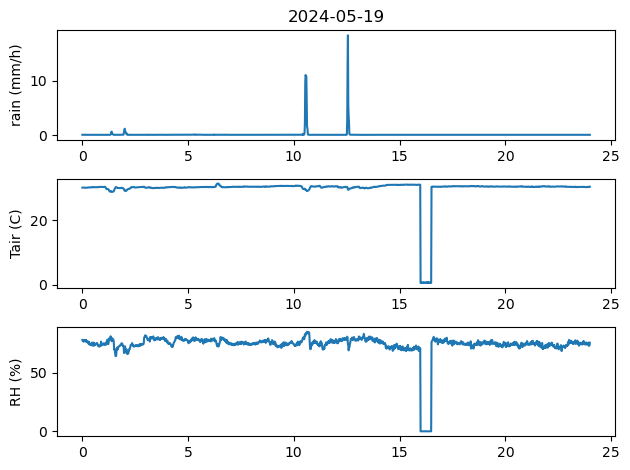

14-element Vector{Any}:
 135
 136
 137
 138
 141
 142
 143
 144
 145
 146
 147
 148
 149
 150

In [7]:
# quick plot daily me2, me1 data
missing_days = []
for yd in 119:150
    if isdir(joinpath(mastdir,"$yd"))
        dtf = plot_me2(yd)
        savefig(joinpath(mastdir,"plot","T_radmr_$(yd)_$dtf.png"))

        plot_trh_org(yd)
        savefig(joinpath(mastdir,"plot","trh_org_$(yd)_$dtf.png"))
    else
        push!(missing_days, yd)
    end
end
@show missing_days